GROUP PROJECT FINAL

# Signs of Smoking: Classifying Smokers Using Biological Health Indicators

Group 005-36: Elena Greenall, Noah Hynds, Dillon Li

### **Introduction**
Despite knowledge that smoking harms nearly every organ in the human body (NIH, 2022), the prevalence of Canadian cigarette smoking in 2020 was 10% (Health Canada, n.d.). Daily smoking has also been associated with increased AST and ALT levels, which are enzymes released in response to liver damage (Jang, 2012). In addition, nicotine increases blood glucose concentration (CDC, 2022), as well as increases triglyceride levels (van der Plas, 2023). As such, the goal of this project will be to use these biological indicators to classify patients based on their probability of being a smoker.  


The question we aim to answer is:<em> is a patient likely to be a smoker, based on AST level, ALT level, fasting blood sugar level, and triglyceride levels? <em>

We will use the Body Signal of Smoking dataset from <a href ="https://www.kaggle.com/datasets/kukuroo3/body-signal-of-smoking/data"> Kaggle</a>, by Kukuroo3. The dataset contains biological health data of smokers and non-smokers. Due to the number of predictor variables contained within this dataset, we have chosen to focus on AST and ALT levels, fasting blood sugar and triglyceride levels as our research has revealed their relevance to smoking.  

### **Methods**

In [ ]:
summary of all methods

To classify smoker status (is (1) or is not (0) a smoker), we are using the following predictor variables:

Fasting blood sugar: blood sugar after approximately 8-12 hours of not eating
Triglyceride: a type of fat found in the body
AST: an enzyme released by the liver when damaged
ALT: an enzyme released by the liver when damaged
The data contains 55692 points, but we will subset 1000 data points (500 smokers, and 500 non-smokers) and will use 75% of this for our training data. Our KNN Classification Model will be created by first splitting our data into training and testing data. Next, we will scale our predictor variables, prepare a recipe and then train the model using a workflow. We will also tune the model for the best K value using cross-validation.

We will visualize the results in a confusion matrix, and creat scatter plots to plot the relationship between ALT/AST levels with smokers and non-smokers, and fasting blood sugar/triglyceride levels with smokers and non-smokers. We will also separate these into male and female for improved visualization.

### **Preliminary Exploratory Data Analysis**

In [1]:
#the first step is to import the necessary libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
set.seed(2024)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [3]:
#next the dataset can be loaded and tidied
smoking_df <- read.csv("https://raw.githubusercontent.com/egreenall1/dsci100_group_project/main/smoking.csv")
colnames(smoking_df) <- c("ID", "gender","age", "height_cm", "weight_kg", "waist_cm", "eyesight_left", "eyesight_right", "hearing_left", "hearing_right", "systolic", "relaxation", "fasting_blood_sugar", "cholesterol", "triglyceride", "HDL", "LDL", "hemoglobin", "urine_protein", "serum_creatine", "AST", "ALT", "Gtp", "oral", "dental_carries", "tartar", "smoking")
smoking_df <- mutate(smoking_df, smoking = as_factor(smoking))

smoking_smoker_sample <- smoking_df |> filter(smoking == 1) |> slice(1:500)
smoking_nonsmoker_sample <- smoking_df |> filter(smoking == 0) |> slice(1:500)
smoking_df <- rbind(smoking_smoker_sample, smoking_nonsmoker_sample)

#select only the predictors we are interested in
smoking_df <- select(smoking_df, gender, AST, ALT, triglyceride, fasting_blood_sugar, smoking)
smoking_df

#split data into training and test data
smoking_split <- initial_split(smoking_df, prop = 0.75, strata = smoking)  
smoking_training_data <- training(smoking_split)
smoking_testing_data <- testing(smoking_split)

#create a summary of our predictors 
smoking_summary <- smoking_training_data |> group_by(smoking) |> summarize(mean(AST), mean(ALT), mean(fasting_blood_sugar), mean(triglyceride))

smoking_summary

gender,AST,ALT,triglyceride,fasting_blood_sugar,smoking
<chr>,<int>,<int>,<int>,<int>,<fct>
M,21,16,182,89,1
M,21,27,68,94,1
M,21,27,210,112,1
M,37,43,318,79,1
M,23,19,119,115,1
M,29,35,77,87,1
M,42,65,94,122,1
M,39,20,80,93,1
M,30,62,85,188,1


smoking,mean(AST),mean(ALT),mean(fasting_blood_sugar),mean(triglyceride)
<fct>,<dbl>,<dbl>,<dbl>,<dbl>
0,23.872,23.05867,96.856,107.5307
1,27.288,29.86133,100.752,149.7787


We can see differences in these predictors between smokers and non-smokers.

Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


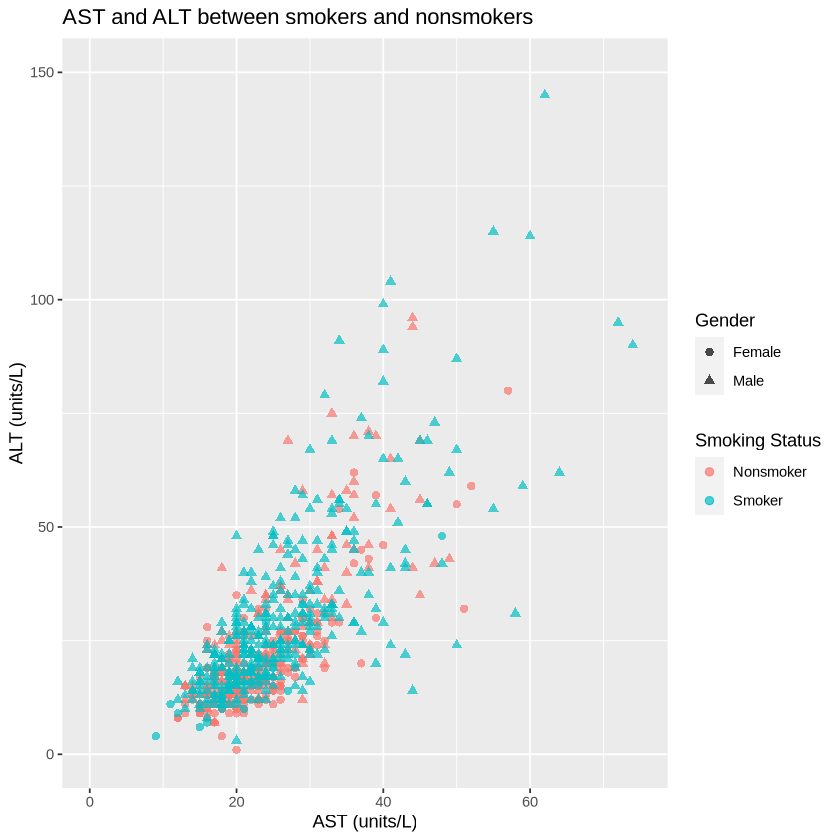

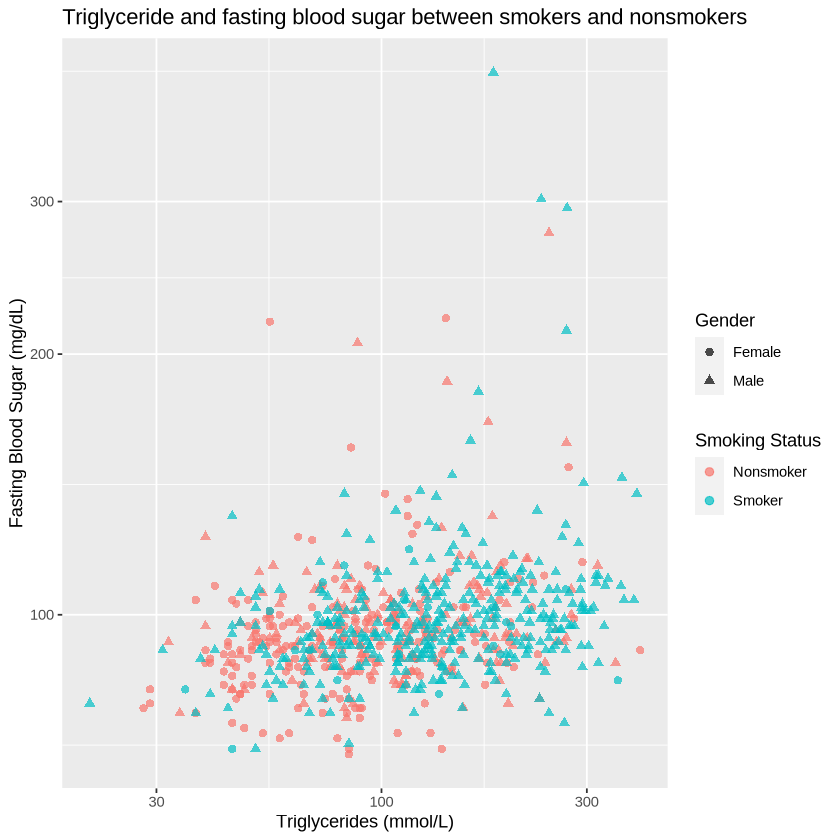

In [5]:
#create a plot of AST vs ALT
smoking_training_plot_AST_ALT <- ggplot(smoking_training_data, aes(x = AST, y = ALT)) + 
geom_point(alpha = 0.7, aes(color = smoking, shape = gender), size = 2) + 
labs(x = "AST (units/L)", y = "ALT (units/L)", title = "AST and ALT between smokers and nonsmokers", color = "Smoking Status", shape = "Gender") + 
xlim(0, 75) + 
ylim(0, 150) +
scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) +
scale_shape_discrete(labels = c("Female", "Male"))

smoking_training_plot_AST_ALT

#create a plot of triglycerides vs fasting blood sugar
smoking_training_plot_triglycerides_fasting_blood_sugar <- ggplot(smoking_training_data, aes(x = triglyceride, y = fasting_blood_sugar)) + 
geom_point(alpha = 0.7, aes(color = smoking, shape = gender), size = 2) + 
labs(x = "Triglycerides (mmol/L)", y = "Fasting Blood Sugar (mg/dL)", title = "Triglyceride and fasting blood sugar between smokers and nonsmokers", color = "Smoking Status", shape = "Gender") + 
scale_x_log10() + 
scale_y_log10() +
scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) +
scale_shape_discrete(labels = c("Female", "Male"))

smoking_training_plot_triglycerides_fasting_blood_sugar

### **Expected Outcomes and Significance**

We expect to find that smokers will tend to have higher levels of triglycerides, fasting blood sugar, ALT and AST levels. 
These findings will be important because they will continue to raise awareness about the biological harm of smoking. Through understanding which biological indicators are most impacted by smoking, preventative care can be taken to reduce the impact of smoking on these measures.  

The findings from this analysis may lead to the following questions:
- What biological indicators are best to measure when determining the effects of smoking on an individual’s health?
- Is there a way to reduce high levels of triglycerides, fasting blood sugar, ALT and AST in individuals who may have challenges with quitting smoking?

### **References**

CDC (2022). Smoking and Diabetes. https://www.cdc.gov/diabetes/library/features/smoking-and-diabetes.html#:~:text=How%20Smoking%20Can%20Lead%20to,cells%20stop%20responding%20to%20insulin

Ch, S. R. (2013). The effect of chronic tobacco smoking and chewing on the lipid profile. Journal of clinical and diagnostic research: JCDR, 7(1), 31.

Health Canada (2022). Canadian Tobacco and Nicotine Survey (CTNS): summary of results for 2020. https://www.canada.ca/en/health-canada/services/canadian-tobacco-nicotine-survey/2020-summary.html

Jang, E.S., Jeong, SH., Hwang, S.H. et al. Effects of coffee, smoking, and alcohol on liver function tests: a comprehensive cross-sectional study. BMC Gastroenterol 12, 145 (2012). https://doi.org/10.1186/1471-230X-12-145

NIH (2022). How Smoking Affects the Heart and Blood Vessels. https://www.nhlbi.nih.gov/health/heart/smoking

van der Plas, A., Antunes, M., Pouly, S., de La Bourdonnaye, G., Hankins, M., & Heremans, A. (2023). Meta-analysis of the effects of smoking and smoking cessation on triglyceride levels. Toxicology Reports, 10, 367-375.

In [5]:
#the first step is to import the necessary libraries
library(tidyverse)
library(tidymodels)
library(RColorBrewer)
set.seed(2024)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [4]:
#next the dataset can be loaded and tidied
smoking_df <- read.csv("https://raw.githubusercontent.com/egreenall1/dsci100_group_project/main/smoking.csv")
colnames(smoking_df) <- c("ID", "gender","age", "height_cm", "weight_kg", "waist_cm", "eyesight_left", "eyesight_right", "hearing_left", "hearing_right", "systolic", "relaxation", "fasting_blood_sugar", "cholesterol", "triglyceride", "HDL", "LDL", "hemoglobin", "urine_protein", "serum_creatine", "AST", "ALT", "Gtp", "oral", "dental_carries", "tartar", "smoking")
smoking_df <- mutate(smoking_df, smoking = as_factor(smoking))

smoking_smoker_sample <- smoking_df |> filter(smoking == 1) |> slice(1:500)
smoking_nonsmoker_sample <- smoking_df |> filter(smoking == 0) |> slice(1:500)
smoking_df <- rbind(smoking_smoker_sample, smoking_nonsmoker_sample)

ERROR: Error in mutate(smoking_df, smoking = as_factor(smoking)): could not find function "mutate"


In [2]:
#select only the predictors we are interested in
smoking_df <- select(smoking_df, gender, AST, ALT, triglyceride, fasting_blood_sugar, smoking)
smoking_df

ERROR: Error in select(smoking_df, gender, AST, ALT, triglyceride, fasting_blood_sugar, : could not find function "select"


We can see differences in these predictors between smokers and non-smokers.

In [ ]:
#split data into training and test data
smoking_split <- initial_split(smoking_df, prop = 0.75, strata = smoking)  
smoking_training_data <- training(smoking_split)
smoking_testing_data <- testing(smoking_split)

In [3]:
#create a summary of our predictors 
smoking_summary <- smoking_training_data |> group_by(smoking) |> summarize(mean(AST), mean(ALT), mean(fasting_blood_sugar), mean(triglyceride))

smoking_summary

ERROR: Error in summarize(group_by(smoking_training_data, smoking), mean(AST), : could not find function "summarize"


Warning message:
“Removed 3 rows containing missing values (`geom_point()`).”


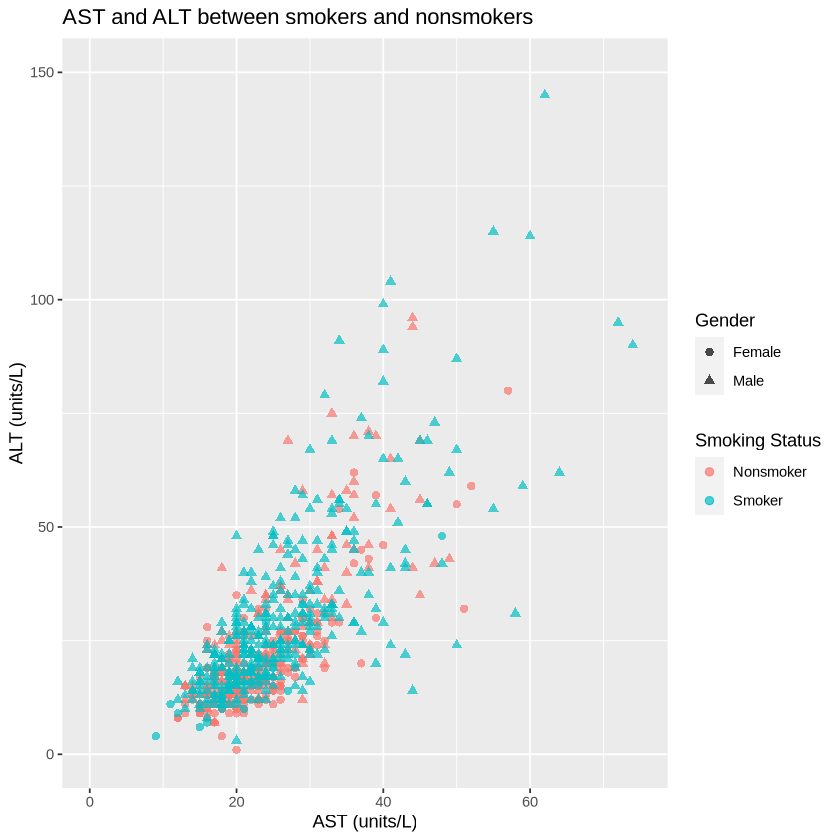

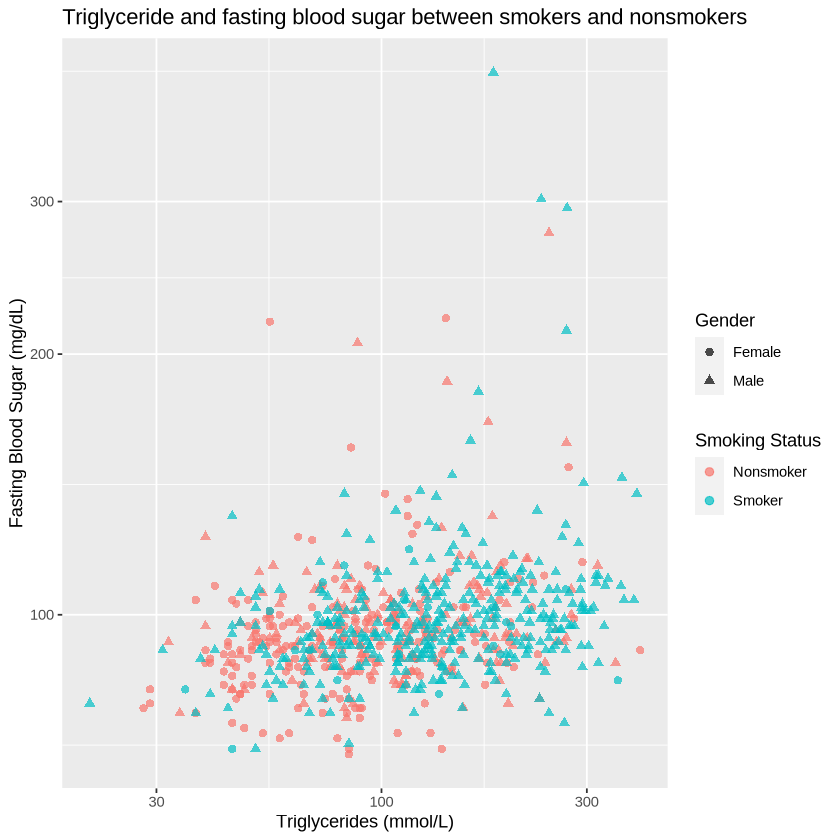

In [5]:
#create a plot of AST vs ALT
smoking_training_plot_AST_ALT <- ggplot(smoking_training_data, aes(x = AST, y = ALT)) + 
geom_point(alpha = 0.7, aes(color = smoking, shape = gender), size = 2) + 
labs(x = "AST (units/L)", y = "ALT (units/L)", title = "AST and ALT between smokers and nonsmokers", color = "Smoking Status", shape = "Gender") + 
xlim(0, 75) + 
ylim(0, 150) +
scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) +
scale_shape_discrete(labels = c("Female", "Male"))

smoking_training_plot_AST_ALT

#create a plot of triglycerides vs fasting blood sugar
smoking_training_plot_triglycerides_fasting_blood_sugar <- ggplot(smoking_training_data, aes(x = triglyceride, y = fasting_blood_sugar)) + 
geom_point(alpha = 0.7, aes(color = smoking, shape = gender), size = 2) + 
labs(x = "Triglycerides (mmol/L)", y = "Fasting Blood Sugar (mg/dL)", title = "Triglyceride and fasting blood sugar between smokers and nonsmokers", color = "Smoking Status", shape = "Gender") + 
scale_x_log10() + 
scale_y_log10() +
scale_colour_discrete(labels = c("Nonsmoker", "Smoker")) +
scale_shape_discrete(labels = c("Female", "Male"))

smoking_training_plot_triglycerides_fasting_blood_sugar

### **Discussion**

summarize what you found
discuss whether this is what you expected to find?
discuss what impact could such findings have?
discuss what future questions could this lead 


o? We expect to find that smokers will tend to have higher levels of triglycerides, fasting blood sugar, ALT and AST leve . 
These findings will be important because they will continue to raise awareness about the biological harm of smoking. Through understanding which biological indicators are most impacted by smoking, preventative care can be taken to reduce the impact of smoking on these measures.  

The findings from this analysis may lead to the following questions:
- What biological indicators are best to measure when determining the effects of smoking on an individual’s health?
- Is there a way to reduce high levels of triglycerides, fasting blood sugar, ALT and AST in individuals who may have challenges with quitting smoking?

### **References**

CDC (2022). Smoking and Diabetes. https://www.cdc.gov/diabetes/library/features/smoking-and-diabetes.html#:~:text=How%20Smoking%20Can%20Lead%20to,cells%20stop%20responding%20to%20insulin

Ch, S. R. (2013). The effect of chronic tobacco smoking and chewing on the lipid profile. Journal of clinical and diagnostic research: JCDR, 7(1), 31.

Health Canada (2022). Canadian Tobacco and Nicotine Survey (CTNS): summary of results for 2020. https://www.canada.ca/en/health-canada/services/canadian-tobacco-nicotine-survey/2020-summary.html

Jang, E.S., Jeong, SH., Hwang, S.H. et al. Effects of coffee, smoking, and alcohol on liver function tests: a comprehensive cross-sectional study. BMC Gastroenterol 12, 145 (2012). https://doi.org/10.1186/1471-230X-12-145

NIH (2022). How Smoking Affects the Heart and Blood Vessels. https://www.nhlbi.nih.gov/health/heart/smoking

van der Plas, A., Antunes, M., Pouly, S., de La Bourdonnaye, G., Hankins, M., & Heremans, A. (2023). Meta-analysis of the effects of smoking and smoking cessation on triglyceride levels. Toxicology Reports, 10, 367-375.